# Пересечение множества отрезков.

## Введение

   Даны n отрезков. Вычислить множество точек, который являются пересечением какой-нибудь пары этих отрезков. 

## Решение #1

   Переберем все пары отрезков и добавим их точку пересечения, если оно есть, в результирующее множество. 

In [18]:
import matplotlib.pyplot as plt
import numpy as np

class Point:
    def __init__(self, x = 0.0, y = 0.0):
        self.x = x
        self.y = y

    def __add__(self, p):
        return Point(self.x + p.x, self.y + p.y)

    def __sub__(self, p):
        return Point(self.x - p.x, self.y - p.y)

    def __neg__(self):
        return Point(-self.x, -self.y)

    def __repr__(self):
        return "(%r, %r)" % (self.x, self.y)


def find_intersections(segments, container):
    n = len(segments)
    for i in range(n):
        for j in range(i + 1, n):
            (flag, point) = segments_intersection(segments[i], segments[j])
            if flag:
                container.add(point)
    container.end()
        

## Ассимптотика

   Очевидно данное решение работает за $O(n^2)$ времени. Дополнительной памяти же тратится $O(1)$, но если наложить инвариант на добавление каждой точки один раз, то расходы памяти так же возрастут до $O(n^2)$.

## Предикат "левый поворот"

Назовем положительную ориентацию левой, а отрицательную - правой (только соглашение; левая ориентация может не совпадать с интуитивным представлением при выборе кососимметричной формы с другим знаком).

Предикат "левый поворот" по набору точек определяет, верно ли, что их ориентация - левая.

$$ \begin{equation*}
turn(a, b, c) = 
 \begin{cases}
   1, &\text{если c лежит слева от направленного отрезка ab,}\\
   -1, &\text{если c лежит справа от направленного отрезка ab,}\\
   0, &\text{если три точки лежат на одной прямой.}
 \end{cases}
\end{equation*} $$

Предикат поворота задается следующим образом:

$$ turn(a, b, c) = sign((b - a) \times (c - a)) = sign 
\left( \begin{array}{cc}
  \left| \begin{array}{cc}
    b_x - a_x & c_x - a_x\\
   b_y - a_y & c_y - a_y
  \end{array} \right| 
\end{array} \right) $$


При наивной реализации уже для точек (3.0, 5.0) Для того, чтобы считать предикат абсолютно точно, рассчитаем с помощью машинного $\varepsilon$ погрешность вычисления определителя $e$. Если значение определителя попало в отрезок [-e, e], то из-за неточности вещественной арифметики оно могло поменять знак. В таком случае посчитаем наше выражение в рациональной арифметике. 

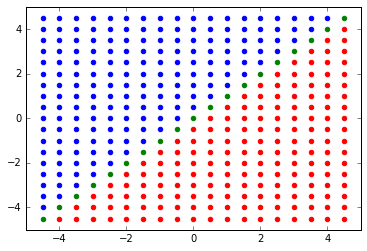

In [17]:
max_val = 5
step = 0.5
colors = ["r", "g", "b"]

def calculate_arg(a, b):
    return abs(a.x * b.y) + abs(b.x * a.y)

def calculate_det(a, b):
    return a.x * b.y - b.x * a.y

def turn(a, b, c):
    e = 8 * np.finfo(float).eps * calculate_arg(b - a, c - a)
    det = calculate_det(b - a, c - a)
    if det > e:
        return 1
    if det < -e:
        return -1

    la = Point(Decimal(a.x), Decimal(a.y))
    lb = Point(Decimal(b.x), Decimal(b.y))
    lc = Point(Decimal(c.x), Decimal(c.y))
    ldet = calculate_det(lb - la, lc - la)
    if ldet > 0:
        return 1
    if ldet < 0:
        return -1
    return 0

x = Point(-max_val, -max_val)
y = Point(max_val, max_val)
for x_i in np.arange(-max_val + step, max_val, step):
    for y_i in np.arange(-max_val + step, max_val, step):
        color = colors[turn(x, y, Point(x_i, y_i)) + 1]
        plt.scatter(x_i, y_i, color = color, s = 20)

plt.axis([-max_val, max_val, -max_val, max_val])
plt.show()

Пересечение двух отрезков.

Два два отрезка координатами их концов $s_1 = (a, b)$, $s_2 = (a, b)$. Проверить, пересекаются ли они?

Если два отрезка не лежат на одной прямой, то необходимым и достаточным условием является то, что концы отрезка $s_1$ лежат по разные стороны относительно отрезка $s_2$ и наоборот. Иначе все предикаты будут равны 0, поэтому проверим их AABB(axis-aligned bounding box) на пересечение. Все это можно записать следующим образом:

$$ s_1 \cap s_2 \Longleftrightarrow 
\begin{equation}
 \begin{cases}
   turn(a, b, c) \cdot turn(a, b, d) \leqslant 0, &\text{ }\\
   turn(c, d, a) \cdot turn(c, d, b) \leqslant 0, &\text{ }\\
   AABB(s_1) \cap AABB(s_2) \ne \varnothing. &\text{ }
 \end{cases}
\end{equation} $$




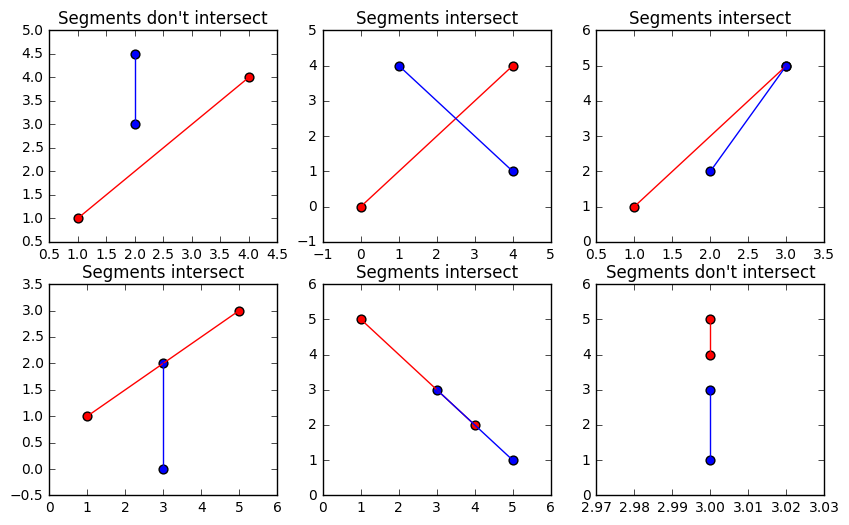

In [6]:
def check_intersect(seg1, seg2):
    a, b = seg1 # a, b - Point, a < b
    c, d = seg2 # c, d - Point, c < d
    
    return turn(a, b, c) * turn(a, b, d) <= 0 and
            turn(c, d, a) * turn(c, d, b) <= 0 and 
            max(a.x, c.x) <= min(b.x, d.x) and 
            max(a.y, c.y) <= min(b.y, d.y)   

## Алгоритм Бентли-Отмана

Теперь научимся решать задачу о пересечении множества отрезков быстрее. Количество пересечений может быть квадрат и с этим ничего не поделаешь. Но если их сильно меньше, то предыдущий алгоритм будет не очень оптимальным. 

Для начала зададим отношение $<$ на точках: ($x1$, $y1$) < ($x2$, $y2$) $\equiv$ $x1$ < $x2$ or $x1$=$x2$ and $y1$<$y2$.

Так же введем понятие событие (event). Будем называть событиями начало и конец отрезков, а так же их пересечение. Каждое событие будет характеризоваться точкой в пространстве, а множество событий последнего типа является ответом на нашу задачу. События упорядочиваются по их координатам, а при равенстве сначала идут события начал, затем пересечений, а последними события концов. Будем обрабатывать события с помощью сканирующей прямой. Сканирующая прямая будет двигаться в порядке увеличения значения по абсцисе, а потом по ординате. В каждый момент времени будем хранить какое-то множество событий и делать модификации, когда дойдем сканирующей прямой до следующего события. Заведем очередь появления событий, куда в начальный момент времени добавим все события начал и концов отрезков. Вытаскивать из очереди будем в порядке увеличения координат событий относительно заданного ранее порядка $<$. 

Так же давайте в каждый момент времени будем хранить набор отрезков $sortedSegSet_{x_i, y_i}$, у которых мы уже обработали событие начала, но еще не обработали событие конца. В каждый момент времени $x_i$, набор будет упорядочен по значению $y_{seg_j}(x_i)$, то есть набор будет сортирован по значению $y$-координаты отрезков в точке $x_i$. 


#### Обозначения

$bef_e$/$aft_e$ - момент времени когда событие $e$ первое обработанное/необработанное.

$prev_e$/$next_e$ - предыдущее/следующее $е$ событие в отсортированном списке всех событий  

### Теорема

$(x_i, y_i)$ - момент времени, $sortedSegSet_{x_i, y_i}$ - отсортированный набор отрезков в момент времени $x_{i}, y_{i}$. $e_{l}$, $e_{r}$ - такие события, что $P_x(e_{l}) \le x_i \le P_x(e_{r})$ $\wedge$ $\forall j : e_j \le e_{l} \vee e_{r} \le e_j$, где $P_x(y)$ - координата x события y. То есть $e_l$ и $e_r$ - ближайщие события. Тогда для любого момента времени ($x_k, y_k$), $e_l \lt (x_k, y_k) \lt e_r$: $sortedSegSet_{x_k, y_k}=sortedSegSet_{x_i, y_i}$

#### Доказательство:

todo.


### Теорема

Пусть $e_n$ - событие пересечения в точке $(p_x, p_y)$, только что взятое из очереди. Тогда $\nexists i, j, k: i \lt j \lt k$, что пары $(sortedSegSet_i, sortedSegSet_j)$ и $(sortedSegSet_j, sortedSegSet_k)$ не пересекаются в точке $(p_x, p_y)$, но $(sortedSegSet_i, sortedSegSet_k)$ пересекаются.

#### Доказательство: